In [1]:
import pandas as pd
from corus import load_lenta
import re
import numpy as np
from tqdm.notebook import tqdm
from multiprocessing import Pool
from pymystem3 import Mystem
from gensim.test.utils import datapath

import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')

import pymorphy2

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Вадим\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [85]:
import pyLDAvis
# import pyLDAvis.gensim as gensimvis
import pyLDAvis.gensim_models as gensimvis

J:\Vadim\envs\TensorFlowEd\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [94]:
path = 'J:/Storage_for_ML/lenta-ru-news.csv.gz'
records = load_lenta(path)
next(records)

LentaRecord(
    url='https://lenta.ru/news/2018/12/14/cancer/',
    title='Названы регионы России с\xa0самой высокой смертностью от\xa0рака',
    text='Вице-премьер по социальным вопросам Татьяна Голикова рассказала, в каких регионах России зафиксирована наиболее высокая смертность от рака, сообщает РИА Новости. По словам Голиковой, чаще всего онкологические заболевания становились причиной смерти в Псковской, Тверской, Тульской и Орловской областях, а также в Севастополе. Вице-премьер напомнила, что главные факторы смертности в России — рак и болезни системы кровообращения. В начале года стало известно, что смертность от онкологических заболеваний среди россиян снизилась впервые за три года. По данным Росстата, в 2017 году от рака умерли 289 тысяч человек. Это на 3,5 процента меньше, чем годом ранее.',
    topic='Россия',
    tags='Общество',
    date=None
)

In [95]:
data = [(record.title, record.topic, record.text, record.tags) for record in records]

In [96]:
type(data)

list

In [97]:
data[0]

('Австрия не\xa0представила доказательств вины российских биатлонистов',
 'Спорт',
 'Австрийские правоохранительные органы не представили доказательств нарушения российскими биатлонистами антидопинговых правил. Об этом сообщил посол России в Вене Дмитрий Любинский по итогам встречи уполномоченного адвоката дипмиссии с представителями прокуратуры страны, передает ТАСС. «Действует презумпция невиновности. Каких-либо ограничений свободы передвижения для команды нет», — добавили в посольстве. Международный союз биатлонистов (IBU) также не будет применять санкции к российским биатлонистам. Все они продолжат выступление на Кубке мира. Полиция нагрянула в отель сборной России в Хохфильцене вечером 12 декабря. Как написал биатлонист Александр Логинов, их считают виновными в махинациях с переливанием крови. Биатлонисту Антону Шипулину, также попавшему в список, полиция нанесла отдельный визит: сейчас он тренируется отдельно в австрийском Обертиллахе. Обвинения спортсмен назвал бредом, а также у

In [37]:
# pd.set_option('display.max_columns', None)  
# pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', None)

In [98]:
data = pd.DataFrame(data, columns=['title','topic','text','tags'])

In [99]:
data.sample(3)

,title,topic,text,tags
339076,Пес спас новорожденных котят в пакете,Из жизни,В штате Айова пес по кличке Реган спас жизнь д...,Все
50157,Задержан второй стрелявший в полицейских в Есс...,Силовые структуры,Cбежавший подозреваемый в нападении на сотрудн...,Криминал
250216,В поезде Душанбе — Москва нашли 32 килограмма ...,Россия,Сотрудники погрануправления ФСБ по Калмыкии и ...,


In [100]:
len(data)

739350

In [101]:
data.topic.value_counts().head(15)

Россия               160518
Мир                  136680
Экономика             79538
Спорт                 64421
Культура              53803
Бывший СССР           53402
Наука и техника       53136
Интернет и СМИ        44675
Из жизни              27611
Дом                   21734
Силовые структуры     19596
Ценности               7766
Бизнес                 7399
Путешествия            6408
69-я параллель         1268
Name: topic, dtype: int64

Для ускорения вычислений оставим тексты из 5 тем:

In [102]:
topics = ['Экономика', 'Спорт', 'Культура', 'Путешествия', 
          'Наука и техника']

data = data[data.topic.isin(topics)]
data.dropna(inplace=True)
len(data)

257306

### Предобработка


Все модели, с которыми мы будем работать далее, работают с предобработанными текстами, поэтому сперва проведем стандартную предобработку текста:

In [103]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

151


In [104]:
bad_word = ['это', 'год', 'хороший', 'который', 'свой', 'крупный', 'всё', 'восемь', 'пять', 'новый',\
            'весь', 'первый', 'также', 'имя', 'большой', 'женщина', 'составить', 'появиться', 'помощь', 'исполнить', 'день', 'упасть',\
            'молодой', 'мир', 'около', 'брат', 'сестра', 'часть', 'удасться', 'нью', 'йорк', 'показать', 'александр', 'владимир',\
            'российский', 'американский', 'европейский', 'китайский', 'английский', 'немецкий','риа', 'общий', 'маленький',\
            'reuters', 'составлять', 'иметь','построить', 'юрий', 'принять', 'сергей', 'алексей', 'возможный','вопрос', \
            'британский', 'сделать', 'пора', 'среди', 'затем','обычный', 'сан', 'associated', 'press', 'причина', 'появиться',\
            'смочь', 'пока', 'дать','лишь','именно', 'отмечать', 'название', 'борис', 'андрей', 'очень', 'найти', 'идти', 'место', 'дважды',\
            'роберт', 'дмитрий', 'виталий', 'павел', 'рио', 'жанейро', 'мутко', 'либо', 'второй', 'передать', 'входить', 'вместо', ''] 
# \ '', '', '', '', ''

In [148]:
'учёный' in stopword_ru

False

In [106]:
stopword_ru += bad_word

In [107]:
with open('stopwords.txt', encoding="utf8") as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]

In [108]:
len(additional_stopwords)

625

In [109]:
len(stopword_ru)

230

In [110]:
stopword_all = set(stopword_ru + additional_stopwords)

In [111]:
len(stopword_all)

695

In [112]:
# stopword_all

In [113]:
morph = pymorphy2.MorphAnalyzer()

J:\Vadim\envs\TensorFlowEd\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
J:\Vadim\envs\TensorFlowEd\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
J:\Vadim\envs\TensorFlowEd\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
J:\Vadim\envs\TensorFlowEd\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs,

In [114]:
words_regex = re.compile('\w+')
stopwords_list = stopwords.words('english')
mystem = Mystem()

<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
C:\Users\Вадим\AppData\Local\Temp\ipykernel_7800\446001417.py:1: DeprecationWarning: invalid escape sequence \w
  words_regex = re.compile('\w+')


In [115]:
def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]

# def lemmatize(words, lemmer = mystem, stopwords = stopword_all):
#     lemmas = lemmer.lemmatize(' '.join(words))
#     return [w for w in lemmas if not w in stopwords 
#             and w.isalpha()]

def lemmatize(words, lemmer = morph, stopwords = stopword_all):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

In [116]:
data.text.iloc[1]

'Сотрудники социальной сети Instagram проанализировали поставленные пользователями смайлики, геолокации и хештеги и опубликовали итоги 2018 года. Об этом сообщается на официальном сайте Instagram. Таким образом, самой счастливой геолокацией Instagram признал Диснейленд в Токио, так как больше всего счастливых смайликов в 2018 году пользователи ставили именно под фотографиями из японского Диснейленда. Также эксперты назвали самый популярный фильтр для лица: им стал фильтр с сердечками на глазах. А, например, самыми часто используемыми хештегами в 2018 году были #metoo, #timesup и #marchforourlives. В ноябре сотрудники британской ассоциации потребителей Which? составили рейтинг самых безопасных стран для путешествий. Специалисты проанализировали 20 самых популярных туристических направлений по четырем критериям: уровень преступности, угроза здоровью, вероятность теракта и стихийных бедствий. Самой безопасной страной по всем параметрам стала Исландия.'

In [117]:
print(preprocess(data.text.iloc[1]))

['сотрудник', 'социальный', 'сеть', 'instagram', 'проанализировать', 'поставить', 'пользователь', 'смайлик', 'геолокация', 'хештег', 'опубликовать', 'итог', 'официальный', 'сайт', 'instagram', 'образ', 'счастливый', 'геолокация', 'instagram', 'признать', 'диснейленд', 'токио', 'счастливый', 'смайлик', 'пользователь', 'ставить', 'фотография', 'японский', 'диснейленд', 'эксперт', 'популярный', 'фильтр', 'лицо', 'фильтр', 'сердечко', 'глаз', 'например', 'часто', 'использовать', 'хештег', 'metoo', 'timesup', 'marchforourlives', 'сотрудник', 'ассоциация', 'потребитель', 'рейтинг', 'безопасный', 'путешествие', 'специалист', 'проанализировать', 'популярный', 'туристический', 'направление', 'четыре', 'критерий', 'уровень', 'преступность', 'угроза', 'здоровье', 'вероятность', 'теракт', 'стихийный', 'бедствие', 'безопасный', 'параметр', 'исландия']


Ниже мы оставим только случайные 50,000 текстов из нашей коллекции, чтобы ускорить вычисления:

In [118]:
data = data.sample(50000)
data.topic.value_counts()

Экономика          15503
Спорт              12641
Культура           10401
Наука и техника    10220
Путешествия         1235
Name: topic, dtype: int64

In [119]:
preprocessed_text = list(tqdm(map(preprocess, data['text']), total=len(data)))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [120]:
data['text'] = preprocessed_text
data.sample(3)

,title,topic,text,tags
298171,В США подсчитали ущерб от простоя экономики из...,Экономика,"[простой, экономика, ураган, сэнди, привести, ...",Все
88848,Турфирма не вернула россиянке 300 тысяч рублей...,Путешествия,"[жительница, санкт, петербург, заплатить, путё...",Происшествия
528597,Индия в третий раз успешно испытала ракету Akash,Наука и техника,"[индийский, военный, третий, прошедший, неделя...",Все


## Модель LDA


Первая модель, которую мы рассмотрим, LDA - латентное размещение Дирихле. Воспользуемся реализацией из библиотеки gensim.

In [121]:
from gensim.models import *
from gensim import corpora

Модель использует векторное представление документов, например, мешок слов (bow), поэтому сперва создадим словарь:

In [122]:
dictionary = corpora.Dictionary(data['text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('lenta.dict')

Векторизуем документы:

In [123]:
corpus = [dictionary.doc2bow(text) for text in data['text']]
corpora.MmCorpus.serialize('lenta.model', corpus) 

Теперь можем обучать модель:

In [124]:
%%time 
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

CPU times: total: 4min 36s
Wall time: 4min 36s


In [125]:
# Сохраняем модель на диск
temp_file = datapath("C:/Users/Вадим/Desktop/GeekBrains/Introduction_to_NLP/Lectures/Lesson_4/model_lda.lda")
lda.save(temp_file)

Посмотрим на получившиеся темы:

In [126]:
topics

['Экономика', 'Спорт', 'Культура', 'Путешествия', 'Наука и техника']

In [127]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(8,
  '0.045*"европа" + 0.041*"россия" + 0.035*"ставка" + 0.034*"период" + 0.033*"показатель" + 0.031*"сша" + 0.028*"достигнуть" + 0.026*"китай" + 0.024*"квартал" + 0.020*"прибыль"'),
 (5,
  '0.130*"россия" + 0.068*"москва" + 0.040*"газпром" + 0.031*"новость" + 0.023*"проект" + 0.023*"иностранный" + 0.022*"пресс" + 0.022*"московский" + 0.020*"служба" + 0.020*"область"'),
 (2,
  '0.040*"бой" + 0.035*"россиянин" + 0.030*"летний" + 0.028*"news" + 0.028*"американец" + 0.028*"правило" + 0.026*"версия" + 0.025*"четвёртый" + 0.022*"поединок" + 0.021*"популярный"'),
 (15,
  '0.055*"контракт" + 0.037*"поставка" + 0.036*"подписать" + 0.033*"соглашение" + 0.028*"конкурс" + 0.025*"центробанк" + 0.021*"переговоры" + 0.020*"сторона" + 0.018*"защита" + 0.017*"условие"'),
 (14,
  '0.066*"учёный" + 0.035*"исследование" + 0.029*"использовать" + 0.027*"обнаружить" + 0.027*"устройство" + 0.027*"система" + 0.025*"журнал" + 0.022*"автор" + 0.020*"опубликовать" + 0.019*"база"'),
 (4,
  '0.039*"финал" + 0.03

На полученные темы можно посмотреть, изобразив их на плоскости с помощью библиотеки pyLDAvis. Чтобы спроецировать темы на плоскость, внутри применяется PCA-разложение.

In [128]:
pyLDAvis.enable_notebook()

In [129]:
%time 
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

CPU times: total: 0 ns
Wall time: 0 ns


J:\Vadim\envs\TensorFlowEd\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


Посмотрим на метрики качества получившейся модели: перплексию и среднюю когерентность:

In [130]:
print(lda.log_perplexity(corpus))

-18.894452968550105


In [131]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Персплексия:  6.226439263495486e-09


In [132]:
coherence_model_lda = CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.5662208842214923


Теперь можно подобрать оптимальное количество тем, опираясь на значение метрик:

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

  0%|          | 0/4 [00:00<?, ?it/s]

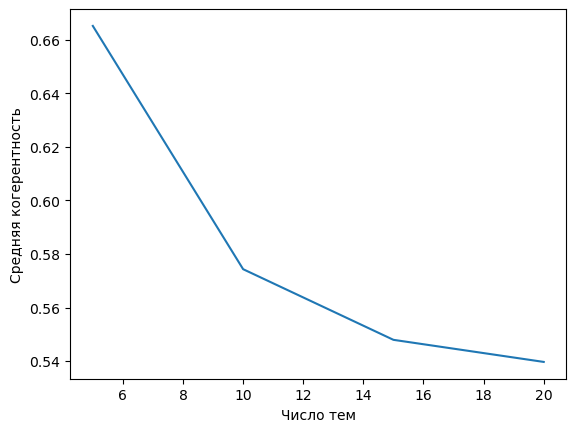

In [134]:
topics_list = [5, 10, 15, 20]
coherences = []

for num in tqdm(topics_list):
    lda_it = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda_it, texts=data['text'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

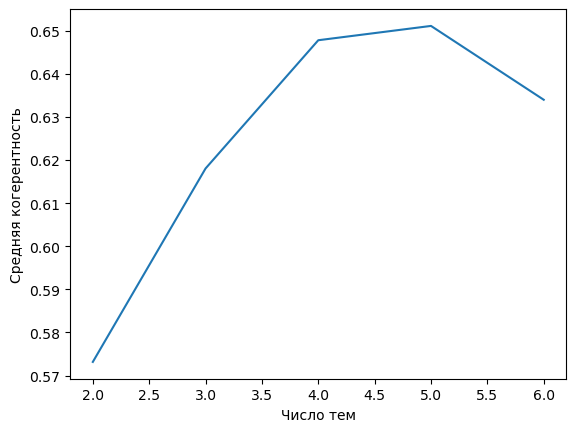

In [135]:
topics_list = [2, 3, 4, 5, 6]
coherences = []

for num in tqdm(topics_list):
    lda_it = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda_it, texts=data['text'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

In [138]:
%%time 
lda_5 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=5, chunksize=50, update_every=1, passes=2)

CPU times: total: 2min 9s
Wall time: 2min 9s


In [139]:
# Сохраняем модель на диск
temp_file = datapath("C:/Users/Вадим/Desktop/GeekBrains/Introduction_to_NLP/Lectures/Lesson_4/model_lda_5.lda")
lda_5.save(temp_file)

In [141]:
topics

['Экономика', 'Спорт', 'Культура', 'Путешествия', 'Наука и техника']

In [140]:
lda_5.show_topics(num_topics=5, num_words=10, formatted=True)

[(0,
  '0.023*"доллар" + 0.017*"миллиард" + 0.014*"рубль" + 0.014*"россия" + 0.012*"миллион" + 0.011*"банк" + 0.008*"акция" + 0.008*"цена" + 0.007*"рынок" + 0.007*"нефть"'),
 (1,
  '0.011*"фильм" + 0.007*"учёный" + 0.006*"картина" + 0.004*"роль" + 0.004*"режиссёр" + 0.004*"актёр" + 0.004*"миллион" + 0.004*"ракета" + 0.004*"автор" + 0.003*"последний"'),
 (2,
  '0.021*"матч" + 0.017*"команда" + 0.013*"сборная" + 0.012*"чемпионат" + 0.012*"клуб" + 0.010*"счёт" + 0.010*"игра" + 0.009*"россия" + 0.007*"победа" + 0.007*"тренер"'),
 (3,
  '0.011*"россия" + 0.007*"москва" + 0.005*"решение" + 0.005*"самолёт" + 0.004*"директор" + 0.004*"новость" + 0.004*"глава" + 0.004*"военный" + 0.004*"тысяча" + 0.004*"агентство"'),
 (4,
  '0.011*"игра" + 0.009*"система" + 0.006*"продажа" + 0.005*"сеть" + 0.005*"использовать" + 0.005*"проект" + 0.004*"сша" + 0.004*"устройство" + 0.004*"сайт" + 0.003*"поступить"')]

In [143]:
%%time 
vis_data = gensimvis.prepare(lda_5, corpus, dictionary)
pyLDAvis.display(vis_data)

J:\Vadim\envs\TensorFlowEd\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


CPU times: total: 34.5 s
Wall time: 36.8 s


Посмотрим на метрики качества получившейся модели: перплексию и среднюю когерентность:

In [144]:
print(lda_5.log_perplexity(corpus))

-8.300387923473174


In [145]:
print('Персплексия: ', np.exp(lda_5.log_perplexity(corpus)))

Персплексия:  0.00024842048063778723


In [146]:
coherence_model_lda = CoherenceModel(model=lda_5, texts=data['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.590949901432254


Подробнее о метриках для оценки тематических моделей:
1. [Перплексия](http://qpleple.com/perplexity-to-evaluate-topic-models/)
2. Когерентность: [один пост](http://qpleple.com/topic-coherence-to-evaluate-topic-models/), [другой пост](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)

In [137]:
ldamodel?

In [65]:
lda_15 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=15, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_15, corpus, dictionary)
pyLDAvis.display(vis_data)

J:\Vadim\envs\TensorFlowEd\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


На другие способы визуализации тематических моделей можно посмотреть [здесь](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#13.-t-SNE-Clustering-Chart).

In [67]:
# Сохраняем модель на диск
temp_file = datapath("C:/Users/Вадим/Desktop/GeekBrains/Introduction_to_NLP/Lectures/Lesson_4/model_lda_15.lda")
lda_15.save(temp_file)